This uses ChemCam cleaned, calibrated spectra from the PDS repository. The data is given in csv format with the first column being the wavelength and the following columns representing the intensities measured in units of photons per channels for each of the $n$ shots.

In [328]:
import pandas as pd
from pathlib import Path

def get_first_sample(data_dict: dict):
    v = list(data_dict.keys())[0]
    return (v, data_dict[v])

In [329]:
data_path = Path("data/data/calib/calib_2015/1600mm/pls/")
sample_names = [f.name for f in data_path.iterdir() if f.is_dir()]

def get_location_dataset_paths_for_sample(sample_name):
    """Get the (five) location datasets for a sample."""
    sample_path = data_path / sample_name
    return [f for f in sample_path.iterdir() if f.is_file() and f.suffix == ".csv"]

def get_dataset_frame(dataset_path):
    with open(dataset_path) as f:
        # find index of last line starting with "#" and skip rows until then
        for i, line in enumerate(f):
            if not line.startswith("#"):
                break
            
        # read csv from that line - columns also start wih "#"
        return pd.read_csv(dataset_path, skiprows=i-1)

def get_preprocessed_sample_data(sample_name: str):
    data = pd.DataFrame()
    exclude_from_avg = ["wave", "mean", "median"]
    first_five_shots = [f"shot{i}" for i in range(1, 6)]

    wavelengths = pd.Series()

    sample_dataset_paths = get_location_dataset_paths_for_sample(sample_name)

    for i, sample_set in enumerate(sample_dataset_paths):
        df = get_dataset_frame(sample_set)

        # strip whitespace from column names
        df.columns = df.columns.str.strip()
        # remove # from column names
        df.columns = df.columns.str.replace("# ", "")

        if i == 0:
            wavelengths = df["wave"]
        else:
            assert wavelengths.equals(df["wave"])

        df.drop(exclude_from_avg, axis=1, inplace=True)
        df.drop(first_five_shots, axis=1, inplace=True)

        if i == 0:
            data = df
        else:
            data.add(df)
            
    data = data.div(len(sample_dataset_paths))
    # re-insert wavelengths to avoid averaging them
    data.insert(0, "wave", wavelengths)

    # add average of all shots and remove individual shots
    shot_cols = [col for col in data.columns if "shot" in col]
    shot_avg = data[shot_cols].mean(axis=1)
    data.drop(shot_cols, axis=1, inplace=True)
    data.insert(1, "shot_avg", shot_avg)
    
    return data


sample_data = {}

for sample_name in sample_names[:5]:
    sample_data[sample_name] = get_preprocessed_sample_data(sample_name)

sample_data.keys()

dict_keys(['jsc1399', 'jsc1469', 'dh4909', 'r65', 'bcr2'])

In [330]:
get_first_sample(sample_data)[1].head()

,wave,shot_avg
0,240.81100,1.237010e+15
1,240.86501,4.724780e+11
2,240.91800,4.975682e+10
3,240.97200,1.512388e+11
4,241.02699,2.774764e+11


In [331]:
# Remove values in the following masks
# The following wavelength ranges are known to have noise: they do not include major element diagnostic peaks.
masks = [
    (240.811, 246.635),
    (338.457, 340.797),
    (382.138, 387.859),
    (473.184, 492.427),
    (849, 905.574)
]

def mask_wavelegths(data: pd.DataFrame, mask):
    return data.loc[~((data["wave"] >= mask[0]) & (data["wave"] <= mask[1]))]

for sample_name, data in sample_data.items():
    for mask in masks:
        sample_data[sample_name] = mask_wavelegths(sample_data[sample_name], mask)

get_first_sample(sample_data)[1].head()

,wave,shot_avg
110,246.68800,7.997177e+10
111,246.74100,7.246205e+10
112,246.79401,6.251668e+10
113,246.84700,5.096286e+10
114,246.89999,4.768218e+10


> The spectra from the first five shots are discarded to minimize any surface contamination, and the subsequent 45 shots from each location are averaged together to give 5 spectra per sample (2040 spectra total).

The reason there are 5 *.csv files for each sample is that they shot at 5 different locations for each sample.
The first 5 shots are discarded to minimize any surface contamination, and the subsequent 45 shots from each location are averaged together to give 5 spectra per sample (2040 spectra total).

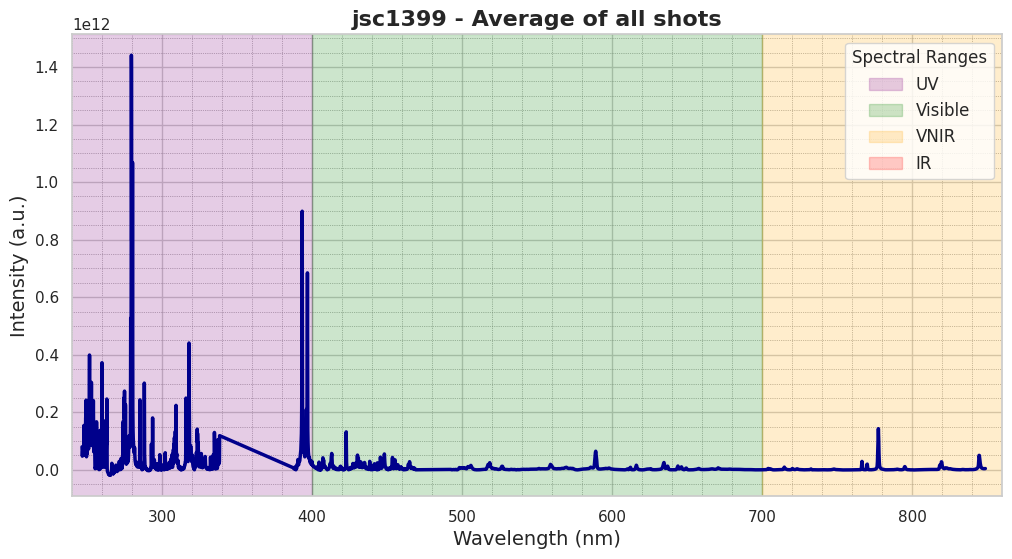

In [332]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sample(sample_name, sample):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    sns.lineplot(x=sample["wave"], y=sample["shot_avg"], linewidth=2.5, linestyle='-', color='darkblue')

    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

    ranges = {
        'UV': (100, 400, 'purple'),
        'Visible': (400, 700, 'green'),
        'VNIR': (700, 1100, 'orange'),
        'IR': (1100, 2500, 'red')
    }

    for label, (start, end, color) in ranges.items():
        plt.axvspan(start, end, alpha=0.2, label=label, color=color)

    plt.title(f"{sample_name} - Average of all shots", fontsize=16, fontweight='bold')
    plt.xlabel("Wavelength (nm)", fontsize=14)
    plt.ylabel("Intensity (a.u.)", fontsize=14) # a.u. = arbitrary units
    plt.legend(title='Spectral Ranges', loc='upper right', fontsize=12)
    plt.xlim(240, 860)
    plt.show()

name, sample = get_first_sample(sample_data)
plot_sample(name, sample)

In [333]:
labels = pd.read_csv("data/data/calib/ccam_calibration_compositions.csv")

labels.head()

,Target,Spectrum Name,Sample Name,SiO2,TiO2,Al2O3,FeOT,MnO,MgO,CaO,Na2O,K2O,MOC total,Used for 2015 calibration,Used for 2021 Mn calibration,Used for 2022 Li calibration
0,AGV2,AGV2,AGV2,59.3,1.05,16.91,6.02,0.099,1.79,5.20,4.19,2.88,97.44,1.0,1.0,1.0
1,BCR-2,BCR2,BCR2,54.1,2.26,13.50,12.42,0.200,3.59,7.12,3.16,1.79,98.14,1.0,1.0,1.0
2,BEN,BEN,BEN,38.2,2.61,10.07,11.61,0.200,13.15,13.87,3.18,1.39,94.28,1.0,1.0,1.0
3,BHVO2,BHVO2,BHVO2,49.9,2.73,13.50,11.07,0.167,7.23,11.40,2.22,0.52,98.74,1.0,1.0,1.0
4,BIR-1a,BIR1,BIR1,47.7,0.97,15.40,10.19,0.176,9.7,13.40,1.81,0.03,99.38,1.0,1.0,1.0


In [334]:
ica = Path("data/data/calib/calib_2015/1600mm/ica/")
pls = Path("data/data/calib/calib_2015/1600mm/pls/")

def get_samples(path):
    return set(map(lambda p: p.name, list(path.glob("*"))))

ica_samples = get_samples(ica)
pls_samples = get_samples(pls)

# samples that are in both pls and ica
print(set(ica_samples) & set(pls_samples))

# samples that are in pls but not in ica
print(set(pls_samples) - set(ica_samples))

# samples that are in ica but not in pls
print(set(ica_samples) - set(pls_samples))

{'jsc1415', 'jsc1387', 'jsc1385', 'gbw07309', 'jsc1438', 'gbw07114', 'umph', 'g22mt', '50tio2', 'jsc1417', 'norite', 'jsc1431', 'granodike', '57a', 'gl7mt', 'jsc1424', 'jsc1378', '54944m', 'hvalfj054', 'jsc1400', 's3a', 'jsc1466', 'ps1', 'dkm1390', 'jdo1', 'cadillac', 'hvalfj017', 'jsc1467', 'swy1', 'jsc1419', 'jsc1404', 'gbw07306', 'jsc1381', 'g28mt', 'g26mt', 'jsc1460', 'jsc1377', 'jsc1445', 'gbw07103', 'r42', 'jsc1374', 'srm98a', 'jsc1447', 'p11mt', 'lp20', 'mix1b', 'jsc1413', 'r45', 'r24', 'ps5', '130', 'g4mt', 'lp11', 'pg1', 'dkm1590', 'pw6', 'pg5', 'sarm17', 'shergottite', '54942m', 'mix2d', 'jsc1459', 'sc7', 'm6mt', 'srm688', '117a', 'p1mt', 'jsc1396', 'lp14', 'r2098m', 'unsak', 'k1919', 'sc3', 'jsc1380', 'jsc1444', 'jsc1428', 'mix3d', 'dkm390', 'srm97a', 'jsc1446', 'gl5mt', 'jsc1418', 'bhvo2', 'mix2b', 's5', 'bk2', 'g14mt', 'dkm3290', 'jsc1420', 'pw3', 'sarm16', 'sc5', 'nat18', 'r11', '3tio2', 'lp4', 'jsc1461', 'mix4d', 'jsc1425', 'sancb', 'mix1o', 'm1mt', 'm5mt', 'jsc1458', 'r

In [335]:
def find_sample_in_labels(sample_name, labels):
    return labels.loc[labels["Sample Name"].str.lower() == sample_name.lower()]

- Train full model to get predictions for all samples for all oxides
- Train 3 sub-models for each oxide

In [336]:
current_sample = find_sample_in_labels(sample_name, labels)
current_sample

,Target,Spectrum Name,Sample Name,SiO2,TiO2,Al2O3,FeOT,MnO,MgO,CaO,Na2O,K2O,MOC total,Used for 2015 calibration,Used for 2021 Mn calibration,Used for 2022 Li calibration
1,BCR-2,BCR2,BCR2,54.1,2.26,13.5,12.42,0.2,3.59,7.12,3.16,1.79,98.14,1.0,1.0,1.0


In [ ]:
# find all sample compositions
sample_compositions = {}


In [337]:
from sklearn.cross_decomposition import PLSRegression

full_model = PLSRegression(n_components=2, scale=False)
# full_model.fit()